MIT License

Copyright (c) 2021  Pablo Daurell Marina,
                    Belén García Puente,
                    Ela Katherine Shepherd Arévalo,
                    Miquel Vera Ramis,
                    Alberto García Doménech,
                    Fernando Bellot Rodríguez,
                    Mateo González de Miguel


Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# Generación de .csv - partidos, palabras extremas y tildes
En este notebook se generan distintos archivos .csv donde se mira la toxicidad "toxic" y "very toxic" modificando ciertos tweets del dataset proporcionado por Newtral-

In [1]:
import pandas as pd
import numpy as np

In [2]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  COLLAB = True
else:
  COLLAB = False

Mounted at /content/drive


In [3]:
if COLLAB == True:
  df = pd.read_csv('/content/drive/Shareddrives/ETICA/dataset_newtral_ucm.csv')
else:
  df = pd.read_csv('../data/dataset_newtral_ucm.csv')

In [4]:
df.head(5)

,twitter_id,text,toxicity,sev_toxicity,profanity,threat,degree1,degree2,degree3,degree_final,degree_predicted,degree_confidence,annotation_date,author_id,slug,twitter_url,party_slug,parliamentary_group_slug
0,1344806255798480896,Feliz 2021 #Adios2020 https://t.co/ULpRE0T2AI,0.012811,0.022777,0.010508,0.077519,0,0,0,0,0,0.969,2021-10-07,2849798849,jose-alberto-herrero-bono,https://twitter.com/herrerobono,partido-popular,gp
1,1344822586396602368,Empezar el año con #CachitosNochevieja no tien...,0.085995,0.068680,0.302721,0.087808,0,0,0,0,0,0.984,2021-10-07,88802757,begona-nasarre-oliva,https://twitter.com/Begonasarre,psoe,gs
2,1344934218145669120,Llegará un momento que los miembros de este Go...,0.478526,0.122059,0.026271,0.513052,2,2,1,2,2,0.868,2021-10-07,593952938,juan-luis-steegmann-olmedillas,https://twitter.com/jlsteeg,vox,gvox
3,1344940715072221184,La frase “ Falsa sensación de seguridad” viene...,0.309307,0.040751,0.009823,0.122409,2,1,1,1,2,0.557,2021-08-25,593952938,juan-luis-steegmann-olmedillas,https://twitter.com/jlsteeg,vox,gvox
4,1344945712128266240,El Comisario político del Gobierno no descansa...,0.194637,0.072107,0.026215,0.249154,2,2,2,2,2,0.964,2021-10-07,1197128623364423680,macarena-montesinos-de-miguel,https://twitter.com/MackMontesinos,partido-popular,gp


In [5]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.5 MB/s 
     |████████████████████████████████| 61 kB 442 kB/s 
     |████████████████████████████████| 3.3 MB 43.8 MB/s 
     |████████████████████████████████| 895 kB 42.4 MB/s 
     |████████████████████████████████| 596 kB 45.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
import transformers
from transformers import pipeline
pipe = pipeline("text-classification", model="Newtral/xlm-r-finetuned-toxic-political-tweets-es")

Downloading:   0%|          | 0.00/753 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/421 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
#LABEL_0 IS TOXIC
#LABEL_1 IS VERY TOXIC
testtext = "Eres un comunista"
toxic_scores = pipe(testtext, return_all_scores=True)
print(toxic_scores[0][1]['score'])
#Prueba del modelo - al escribir un tweet nos da el valor de ambas toxicidades. En esta celda imprimimos el valor "very toxic" del texto "Eres un comunista"

0.13335810601711273


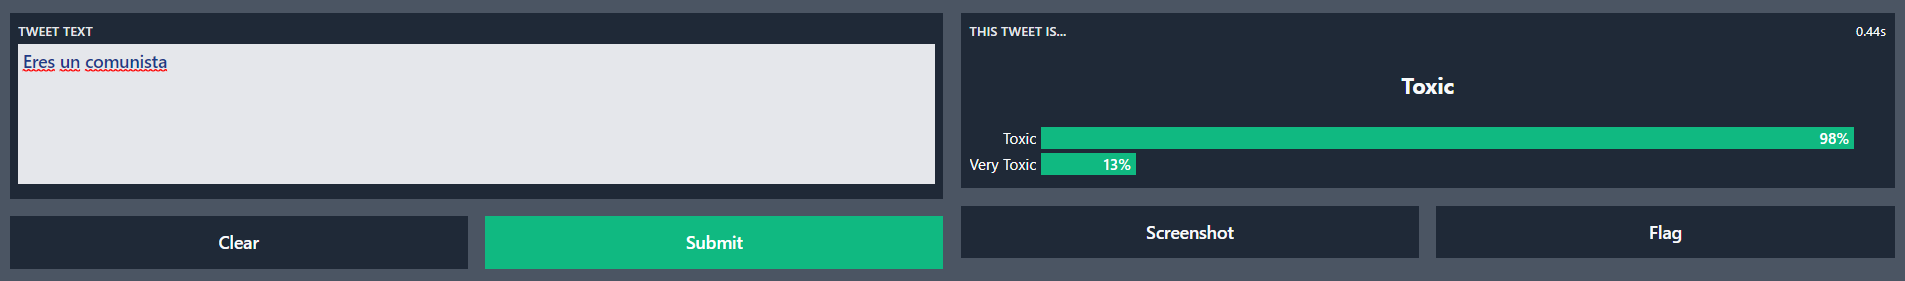

## Modificación de tweets - partidos
En esta sección se generan todos los .csv con el nombre "tweet_mods_political_parties_[PARTY].csv".
Por cada tweet del dataset que contenga un nombre de un partido en concreto[PARTY], se modifica ese tweet cambiando esa palabra por todos los otros partidos políticos y se va comparando las toxicidad de cada tweet modificado. Finalmente en un dataframe mostramos la toxicidad del tweet modificado con más toxicidad y el partido con el que ha surgido este valor.

In [ ]:
column_names = ["twitter_id", "original_text", "slug", "party_slug", "party_original", "toxic_original", "very_toxic_original", "most_toxic_party", "most_toxic_party_toxicity", "most_verytoxic_party" ,"most_verytoxic_party_toxicity", "PARTIDO_toxic", "PARTIDO_verytoxic"]
df_wordmod = pd.DataFrame(columns = column_names)
df_wordmod

,twitter_id,original_text,slug,party_slug,party_original,toxic_original,very_toxic_original,most_toxic_party,most_toxic_party_toxicity,most_verytoxic_party,most_verytoxic_party_toxicity,PARTIDO_toxic,PARTIDO_verytoxic


In [ ]:
#Se ha ido modificando "palabras_politicas_solouno" para poder generar distintos csv de distintos partidos
palabras_politicas_solouno = ["Partido popular"]
palabras_politicas = ["PP", "PSOE", "VOX", "PODEMOS", "Vox", "Cs", "Ciudadanos", "Unidas Podemos", "Partido popular"]

In [ ]:

for substring in palabras_politicas_solouno:
  for idx, row in df.iterrows():
    if substring in row.text:
      row_tox_value = pipe(row.text, return_all_scores=True)[0][0]['score']
      row_vtox_value = pipe(row.text, return_all_scores=True)[0][1]['score']
      maxt = row_tox_value
      maxtp = substring
      maxvt = row_vtox_value
      maxvtp = substring
      for otro in palabras_politicas:
        if substring != otro:
          if pipe(row.text.replace(substring, otro), return_all_scores=True)[0][0]['score'] > maxt:
            maxt = pipe(row.text.replace(substring, otro), return_all_scores=True)[0][0]['score']
            maxtp = otro
          if pipe(row.text.replace(substring, otro), return_all_scores=True)[0][1]['score'] > maxvt:
            maxvt = pipe(row.text.replace(substring, otro), return_all_scores=True)[0][1]['score']
            maxvtp = otro

      new_row = {'twitter_id':row.twitter_id, 'original_text':row.text, 'slug':row.slug, 'party_slug':row.party_slug, 'party_original': substring, 'toxic_original':row_tox_value , 'very_toxic_original':row_vtox_value,'most_toxic_party':maxtp, 'most_toxic_party_toxicity': maxt, 'most_verytoxic_party':maxvtp, 'most_verytoxic_party_toxicity': maxvt, 'PARTIDO_toxic':pipe(row.text.replace(substring, "partido"), return_all_scores=True)[0][0]['score'],'PARTIDO_verytoxic':pipe(row.text.replace(substring, "partido"), return_all_scores=True)[0][1]['score']}
      df_wordmod = df_wordmod.append(new_row, ignore_index = True)
      

In [ ]:
df_wordmod = df_wordmod.drop_duplicates()

In [ ]:
df_wordmod

,twitter_id,original_text,slug,party_slug,party_original,toxic_original,very_toxic_original,most_toxic_party,most_toxic_party_toxicity,most_verytoxic_party,most_verytoxic_party_toxicity,PARTIDO_toxic,PARTIDO_verytoxic
0,1451867755930607619,El Partido popular defiende siempre la liberta...,carlos-rojas-garcia,partido-popular,Partido popular,0.011729,0.001201,PP,0.076033,Ciudadanos,0.001235,0.009506,0.001289


In [ ]:
#df_wordmod.to_csv('/content/drive/Shareddrives/ETICA/tweet_mods_political_parties_Partido_popular.csv', index=False)  

## Modificación de tweets - Fascismo/comunismo

Primero cogemos todos los tweets que contengan las palabras "fascista", "fascismo", "comunista" y  "comunismo". Después miramos las toxicidades "toxic" y "very toxic" de tanto el tweet original como el tweet modificado (cambiamos la palabra "fascista" por "comunista"...)
En un dataframe mostramos todas las toxicidades, y además la palabra que ha resultado dar un valor más alto de toxicidad.

In [ ]:
column_names = ["twitter_id", "original_text", "slug", "party_slug", "comuni_toxic", "comuni_very_toxic", "fascis_toxic", "fascis_very_toxic", "most_toxic", "most_very_toxic"]
df_wordmod = pd.DataFrame(columns = column_names)
df_wordmod
#Nuevo dataframe vacío

,twitter_id,original_text,slug,party_slug,comuni_toxic,comuni_very_toxic,fascis_toxic,fascis_very_toxic,most_toxic,most_very_toxic


In [ ]:
for idx, row in df.iterrows():
  if "comunista" in row.text:
    maxtox = ""
    maxvtox = ""
    ##
    com_row_tox_value = pipe(row.text, return_all_scores=True)[0][0]['score']
    com_row_vtox_value = pipe(row.text, return_all_scores=True)[0][1]['score']
    fas_row_tox_value = pipe(row.text.replace("comunista", "fascista"), return_all_scores=True)[0][0]['score']
    fas_row_vtox_value = pipe(row.text.replace("comunista", "fascista"), return_all_scores=True)[0][1]['score']
    ##
    if com_row_tox_value > fas_row_tox_value:
      maxtox = "comunista"
    elif fas_row_tox_value > com_row_tox_value:
      maxtox = "fascista"
    ##
    if com_row_vtox_value > fas_row_vtox_value:
      maxvtox = "comunista"
    elif fas_row_vtox_value > com_row_vtox_value:
      maxvtox = "fascista"
    ##
    new_row = {'twitter_id':row.twitter_id, 'original_text':row.text, 'slug':row.slug, 'party_slug':row.party_slug, 'comuni_toxic': com_row_tox_value, 'comuni_very_toxic':com_row_vtox_value , 'fascis_toxic':fas_row_tox_value,'fascis_very_toxic':fas_row_vtox_value, 'most_toxic':maxtox, 'most_very_toxic':maxvtox}
    df_wordmod = df_wordmod.append(new_row, ignore_index = True)
  if "fascista" in row.text:
    maxtox = ""
    maxvtox = ""
    #
    fas_row_tox_value = pipe(row.text, return_all_scores=True)[0][0]['score']
    fas_row_vtox_value = pipe(row.text, return_all_scores=True)[0][1]['score']
    com_row_tox_value = pipe(row.text.replace("fascista", "comunista"), return_all_scores=True)[0][0]['score']
    com_row_vtox_value = pipe(row.text.replace("fascista", "comunista"), return_all_scores=True)[0][1]['score']
    ##
    if com_row_tox_value > fas_row_tox_value:
      maxtox = "comunista"
    elif fas_row_tox_value > com_row_tox_value:
      maxtox = "fascista"
    ##
    if com_row_vtox_value > fas_row_vtox_value:
      maxvtox = "comunista"
    elif fas_row_vtox_value > com_row_vtox_value:
      maxvtox = "fascista"
    ##
    new_row = {'twitter_id':row.twitter_id, 'original_text':row.text, 'slug':row.slug, 'party_slug':row.party_slug, 'comuni_toxic': com_row_tox_value, 'comuni_very_toxic':com_row_vtox_value , 'fascis_toxic':fas_row_tox_value,'fascis_very_toxic':fas_row_vtox_value, 'most_toxic':maxtox, 'most_very_toxic':maxvtox}
    df_wordmod = df_wordmod.append(new_row, ignore_index = True)
##########################################################################################################
  if "comunismo" in row.text:
    maxtox = ""
    maxvtox = ""
    ##
    com_row_tox_value = pipe(row.text, return_all_scores=True)[0][0]['score']
    com_row_vtox_value = pipe(row.text, return_all_scores=True)[0][1]['score']
    fas_row_tox_value = pipe(row.text.replace("comunismo", "fascismo"), return_all_scores=True)[0][0]['score']
    fas_row_vtox_value = pipe(row.text.replace("comunismo", "fascismo"), return_all_scores=True)[0][1]['score']
    ##
    if com_row_tox_value > fas_row_tox_value:
      maxtox = "comunismo"
    elif fas_row_tox_value > com_row_tox_value:
      maxtox = "fascismo"
    ##
    if com_row_vtox_value > fas_row_vtox_value:
      maxvtox = "comunismo"
    elif fas_row_vtox_value > com_row_vtox_value:
      maxvtox = "fascismo"
    ##
    new_row = {'twitter_id':row.twitter_id, 'original_text':row.text, 'slug':row.slug, 'party_slug':row.party_slug, 'comuni_toxic': com_row_tox_value, 'comuni_very_toxic':com_row_vtox_value , 'fascis_toxic':fas_row_tox_value,'fascis_very_toxic':fas_row_vtox_value, 'most_toxic':maxtox, 'most_very_toxic':maxvtox}
    df_wordmod = df_wordmod.append(new_row, ignore_index = True)
  if "fascismo" in row.text:
    maxtox = ""
    maxvtox = ""
    #
    fas_row_tox_value = pipe(row.text, return_all_scores=True)[0][0]['score']
    fas_row_vtox_value = pipe(row.text, return_all_scores=True)[0][1]['score']
    com_row_tox_value = pipe(row.text.replace("fascismo", "comunismo"), return_all_scores=True)[0][0]['score']
    com_row_vtox_value = pipe(row.text.replace("fascismo", "comunismo"), return_all_scores=True)[0][1]['score']
    ##
    if com_row_tox_value > fas_row_tox_value:
      maxtox = "comunismo"
    elif fas_row_tox_value > com_row_tox_value:
      maxtox = "fascismo"
    ##
    if com_row_vtox_value > fas_row_vtox_value:
      maxvtox = "comunismo"
    elif fas_row_vtox_value > com_row_vtox_value:
      maxvtox = "fascismo"
    ##
    new_row = {'twitter_id':row.twitter_id, 'original_text':row.text, 'slug':row.slug, 'party_slug':row.party_slug, 'comuni_toxic': com_row_tox_value, 'comuni_very_toxic':com_row_vtox_value , 'fascis_toxic':fas_row_tox_value,'fascis_very_toxic':fas_row_vtox_value, 'most_toxic':maxtox, 'most_very_toxic':maxvtox}
    df_wordmod = df_wordmod.append(new_row, ignore_index = True)

In [ ]:
df_wordmod = df_wordmod.drop_duplicates()

In [ ]:
df_wordmod

,twitter_id,original_text,slug,party_slug,comuni_toxic,comuni_very_toxic,fascis_toxic,fascis_very_toxic,most_toxic,most_very_toxic
0,1345796272696020992,China comunista 'inunda' EEUU de espías: Los a...,juan-luis-steegmann-olmedillas,vox,0.979762,0.063240,0.987422,0.153830,fascista,fascista
1,1345839019293368320,La coherencia socialista: dicen una cosa y hac...,NaN,NaN,0.977812,0.013881,0.978280,0.013820,fascista,comunista
2,1346915765522472960,@realDonaldTrump ha dado un paso más allá y es...,german-renau-martinez,psoe,0.973739,0.015639,0.986864,0.033582,fascismo,fascismo
3,1346920186494951425,Fanáticos fascistas asaltan el Capitolio ampar...,zaida-cantera-de-castro,psoe,0.990875,0.996876,0.990972,0.997229,fascista,fascista
4,1346928196529377282,“La democracia es algo delicado que hay que pr...,lidia-guinart-moreno,psoe,0.013606,0.001135,0.035886,0.000816,fascismo,comunismo
...,...,...,...,...,...,...,...,...,...,...
296,1452515131963871232,Un titular q refleja las ganas de cambio de lo...,vicente-betoret-coll,partido-popular,0.954154,0.008071,0.968340,0.012101,fascista,fascista
297,1453451029467500545,👉 ⁦@vox_es⁩ se congratula de haber tumbado el ...,emilio-jesus-del-valle-rodriguez,vox,0.975227,0.015452,0.991678,0.096476,fascista,fascista
298,1448963499288371212,En la concentración de solidaridad con el sind...,miguel-angel-bustamante-martin,izquierda-unida,0.795117,0.002535,0.788176,0.002685,comunista,fascista
299,1450194230090113032,Las vacunas de la china comunista han vacunado...,juan-luis-steegmann-olmedillas,vox,0.926199,0.009734,0.950484,0.015907,fascista,fascista


In [ ]:
#df_wordmod.to_csv('/content/drive/Shareddrives/ETICA/tweet_mods_political_parties_Fascism_communism.csv', index=False)  

## Modificación de tweets - tildes
En esta sección se modifican todos los tweets que contengan tildes y se les quitan las tildes. Se mira la toxicidad de ambos tweets y se comparan, plasmando los resultados en un dataframe.

In [7]:
column_names = ["twitter_id", "original_text", "slug", "party_slug", "toxic_original", "very_toxic_original","toxic_noaccent", "very_toxic_noaccent", "most_toxic_grammar", "most_verytoxic_grammar"]
df_wordmod = pd.DataFrame(columns = column_names)
df_wordmod

,twitter_id,original_text,slug,party_slug,toxic_original,very_toxic_original,toxic_noaccent,very_toxic_noaccent,most_toxic_grammar,most_verytoxic_grammar


In [8]:
def remove_accents(s):
  if ('á' in s):
    s = s.replace('á', 'a')
  if ('é' in s):
    s = s.replace('é', 'e')
  if ('í' in s):
    s = s.replace('í', 'i') 
  if ('ó' in s):
    s = s.replace('ó', 'o')
  if ('ú' in s):
    s = s.replace('ú', 'u')
    
  return s

In [9]:
for idx, row in df.iterrows():
  if ("á" in row.text or "é" in row.text or "í" in row.text or "ó" in row.text or "ú" in row.text):
    acc_row_tox_value = pipe(row.text, return_all_scores=True)[0][0]['score']
    acc_row_vtox_value = pipe(row.text, return_all_scores=True)[0][1]['score']
    noacc_row_tox_value = pipe(remove_accents(row.text), return_all_scores=True)[0][0]['score']
    noacc_row_vtox_value = pipe(remove_accents(row.text), return_all_scores=True)[0][1]['score']
    ##
    maxtox = ""
    maxvtox = ""
    if acc_row_tox_value > noacc_row_tox_value:
      maxtox = "con tildes"
    elif noacc_row_tox_value > acc_row_tox_value:
      maxtox = "sin tildes"
    ##
    if acc_row_vtox_value > noacc_row_vtox_value:
      maxvtox = "con tildes"
    elif noacc_row_vtox_value > acc_row_vtox_value:
      maxvtox = "sin tildes"
    ##

    new_row = {'twitter_id':row.twitter_id, 'original_text':row.text, 'slug':row.slug, 'party_slug':row.party_slug, 'toxic_original': acc_row_tox_value, 'very_toxic_original':acc_row_vtox_value , 'toxic_noaccent':noacc_row_tox_value,'very_toxic_noaccent':noacc_row_vtox_value, 'most_toxic_grammar': maxtox, 'most_verytoxic_grammar':maxvtox}
    df_wordmod = df_wordmod.append(new_row, ignore_index = True)
      

In [10]:
df_wordmod.head(10)

,twitter_id,original_text,slug,party_slug,toxic_original,very_toxic_original,toxic_noaccent,very_toxic_noaccent,most_toxic_grammar,most_verytoxic_grammar
0,1344934218145669120,Llegará un momento que los miembros de este Go...,juan-luis-steegmann-olmedillas,vox,0.995289,0.996132,0.996114,0.993316,sin tildes,con tildes
1,1344940715072221184,La frase “ Falsa sensación de seguridad” viene...,juan-luis-steegmann-olmedillas,vox,0.987947,0.056416,0.985783,0.040629,con tildes,con tildes
2,1344945712128266240,El Comisario político del Gobierno no descansa...,macarena-montesinos-de-miguel,partido-popular,0.995368,0.995748,0.995438,0.995655,sin tildes,con tildes
3,1344962035277320193,Desde @CiudadanosCs presentamos una enmienda p...,NaN,NaN,0.016391,0.000838,0.017045,0.000813,sin tildes,con tildes
4,1344967124264116230,Y que mejor forma de dar la bienvenida al 2021...,maria-angeles-marra-dominguez,psoe,0.004446,0.002959,0.004253,0.003146,con tildes,sin tildes
5,1344978091807035392,Un año de oposición: a la peor pandemia PP y V...,maria-angeles-marra-dominguez,psoe,0.525792,0.001039,0.894197,0.002838,sin tildes,sin tildes
6,1344979996088086528,España 🇪🇸 es desde hoy pionera en permisos por...,jose-luis-aceves-galindo,psoe,0.972787,0.011368,0.959439,0.008296,con tildes,con tildes
7,1344988686849630208,Mi deseo es que este año 2021 las sociedades c...,juan-luis-steegmann-olmedillas,vox,0.993652,0.997414,0.994997,0.996037,sin tildes,con tildes
8,1344998177146105857,La zona de prosperidad compartida de la que ha...,NaN,NaN,0.986026,0.033563,0.982653,0.023665,con tildes,con tildes
9,1345018443100278786,"Cáceres, esa ciudad que todo el que la visita ...",cesar-joaquin-ramos-esteban,psoe,0.004547,0.004564,0.005015,0.003427,sin tildes,con tildes


In [11]:
df_wordmod.to_csv('/content/drive/Shareddrives/ETICA/tweet_mods_accents.csv', index=False)  